In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
from patsy import dmatrix

## 0) Data Load

In [2]:
train_16 = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'],dtype={'parcelid':int})

In [3]:
prop_16 = pd.read_csv('properties_2016.csv',dtype={'fireplaceflag':object, 'taxdelinquencyflag':object, 'fireplaceflag':object, 'propertyzoningdesc':object, 'propertycountylandusecode':object, 'hashottuborspa':object})

In [4]:
train_df1 = pd.merge(train_16,prop_16,on='parcelid', how ='left')

In [5]:
train_df = train_df1.copy()

train_17 = pd.read_csv('train_2017.csv',parse_dates=['transactiondate'],dtype={"parcelid": int})

prop_17 = pd.read_csv('properties_2017.csv',dtype={"parcelid": int})

train_df2 = pd.merge(train_17,prop_17,on='parcelid', how ='left',dtype={"parcelid": int})

train_df = pd.concat([train_df1,train_df2])

17년 데이터는 생략한 상태

# 1) Analysis Outer-Feature

## 1.1) Overview the Inner-feature data

- 'architecturalstyletypeid'
- 'bathroomcnt'
- 'calculatedbathnbr'
- 'threequarterbathnbr'
- 'fullbathcnt'
- 'bedroomcnt'
- 'roomcnt’
- 'garagecarcnt'
- 'garagetotalsqft'
- 'airconditioningtypeid'
- 'fireplacecnt'
- 'fireplaceflag'
- 'hashottuborspa'
- 'heatingorsystemtypeid'
- 'poolcnt'
- 'poolsizesum'
- 'pooltypeid10'
- 'pooltypeid2'
- 'pooltypeid7'

- inner_feature는 총 18개의 컬럼으로 이뤄져 있고, 분류 기준은 집 구성하는 미시적 요소들에 관한 것이다.
- 화장실 갯수를 의미하는 컬럼이 중복된다.(bathroomcnt, calculatebathnbr)

In [6]:
inner_feature= [
    '에어컨 아이디',
    '화장실 갯수',
    '화장실 갯수',
    '집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)',
    '풀옵션 화장실의 갯수',
    '침실 갯수',
     '주거지에있는 총 객실 수',
    '차고 갯수',
    '차고 평방(크기)',
    '에이컨 아이디',
    '벽난로 수',
    '벽난로가 있는지 없는지',
    '난방 시스템의 유무',
    '난방 시스템의 타입',
    '수영장 갯수',
    '수영장 크기',
     '스파 또는 온천',
     '스파 / 온수 욕조가있는 수영장',
    ' 온수 욕조가없는 수영장'
]

In [7]:
inner_feature_col=[
'airconditioningtypeid',
'bathroomcnt',
'calculatedbathnbr',
'threequarterbathnbr',
'fullbathcnt',
'bedroomcnt',
'roomcnt',
'garagecarcnt',
'garagetotalsqft',
'airconditioningtypeid',
'fireplacecnt',
'fireplaceflag',
'hashottuborspa',
'heatingorsystemtypeid',
'poolcnt',
'poolsizesum',
'pooltypeid10',
'pooltypeid2',
'pooltypeid7'
]

In [8]:
inner_df = pd.DataFrame(columns=['name','feature'])
inner_df.name = inner_feature_col
inner_df.feature = inner_feature
inner_df

,name,feature
0,airconditioningtypeid,에어컨 아이디
1,bathroomcnt,화장실 갯수
2,calculatedbathnbr,화장실 갯수
3,threequarterbathnbr,집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)
4,fullbathcnt,풀옵션 화장실의 갯수
5,bedroomcnt,침실 갯수
6,roomcnt,주거지에있는 총 객실 수
7,garagecarcnt,차고 갯수
8,garagetotalsqft,차고 평방(크기)
9,airconditioningtypeid,에이컨 아이디


## 1.2) Datatype of Columns

In [9]:
print(train_df[inner_feature_col].dtypes,end='\n\n'),
print('Number of inner_feature_col:  {}'.format(len(inner_feature_col)))

airconditioningtypeid    float64
bathroomcnt              float64
calculatedbathnbr        float64
threequarterbathnbr      float64
fullbathcnt              float64
bedroomcnt               float64
roomcnt                  float64
garagecarcnt             float64
garagetotalsqft          float64
airconditioningtypeid    float64
fireplacecnt             float64
fireplaceflag             object
hashottuborspa            object
heatingorsystemtypeid    float64
poolcnt                  float64
poolsizesum              float64
pooltypeid10             float64
pooltypeid2              float64
pooltypeid7              float64
dtype: object

Number of inner_feature_col:  19


- Inner_feature에는 18개의 컬럼이 있고, 두 개의 object 자료형과 16개의 float형이 있다.
- numerical data, object data 를 가지고 있는 컬럼들을 나눠서 분석을 하도록 하겠다.

In [10]:
inner_numeric = []
inner_object = []
for col in inner_feature_col:
    if train_df[col].dtypes == 'float64':
        inner_numeric.append(col)
    else:inner_object.append(col)

In [11]:
inner_numeric
print(len(inner_numeric))

17


In [12]:
inner_object
print(len(inner_object))

2


## 1.3) Individual columns' feature analysis

### scatter plot about numerical data

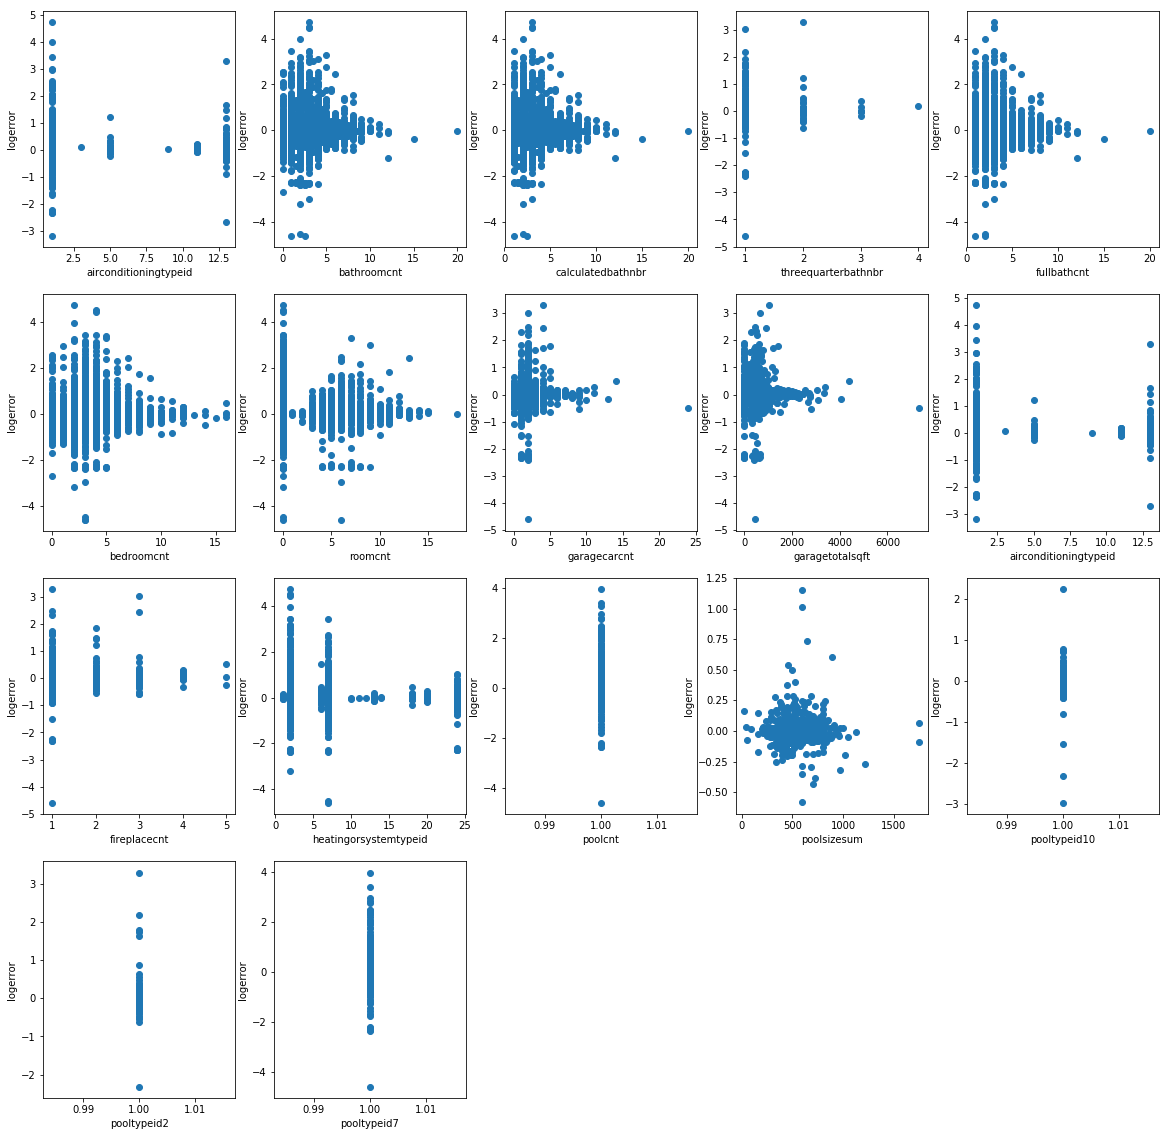

In [13]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(inner_numeric):
    plt.subplot(4,5,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- float 자료형에 대한 scatterplot을 그려본 결과 대부분의 분포 형태가 continuous하지 않고, discrete한 분포를 띄고 있다고 보여진다.
- 즉, numeric category를 가지고 있을 수 있는 컬럼이라고 생각하고, 카테고리의 갯수를 40개 미만으로 가지는 데이터에 대해서 다시 분포에 대해 시각화해본다.

In [14]:
discrete_inner_col = []
for idx,col in enumerate(inner_numeric):
    if len(train_df[col].value_counts())<40:
        print(train_df[col].value_counts())
        discrete_inner_col.append(col)
len(discrete_inner_col)

1.0     26668
13.0     1833
5.0       215
11.0       63
9.0         1
3.0         1
Name: airconditioningtypeid, dtype: int64
2.0     36534
3.0     19946
1.0     15035
2.5      8091
4.0      3743
1.5      1641
0.0      1165
5.0      1142
3.5      1091
4.5       795
6.0       448
5.5       253
7.0       155
8.0       114
6.5        54
9.0        36
10.0       14
7.5         9
11.0        3
12.0        3
8.5         1
20.0        1
15.0        1
Name: bathroomcnt, dtype: int64
2.0     36534
3.0     19946
1.0     15035
2.5      8084
4.0      3743
1.5      1636
5.0      1142
3.5      1088
4.5       793
6.0       448
5.5       253
7.0       155
8.0       114
6.5        54
9.0        36
10.0       14
7.5         9
11.0        3
12.0        3
8.5         1
20.0        1
15.0        1
Name: calculatedbathnbr, dtype: int64
1.0    11912
2.0       90
3.0        6
4.0        1
Name: threequarterbathnbr, dtype: int64
2.0     44635
3.0     21035
1.0     16671
4.0      4541
5.0      1392
6.0       49

15

40 개 미만의 카테고리를 가지는 discrete data column 이 총 15개가 나왔다. 이 컬럼들에 대해서 stripplot,viloinplot을 적용해 시각화한다.

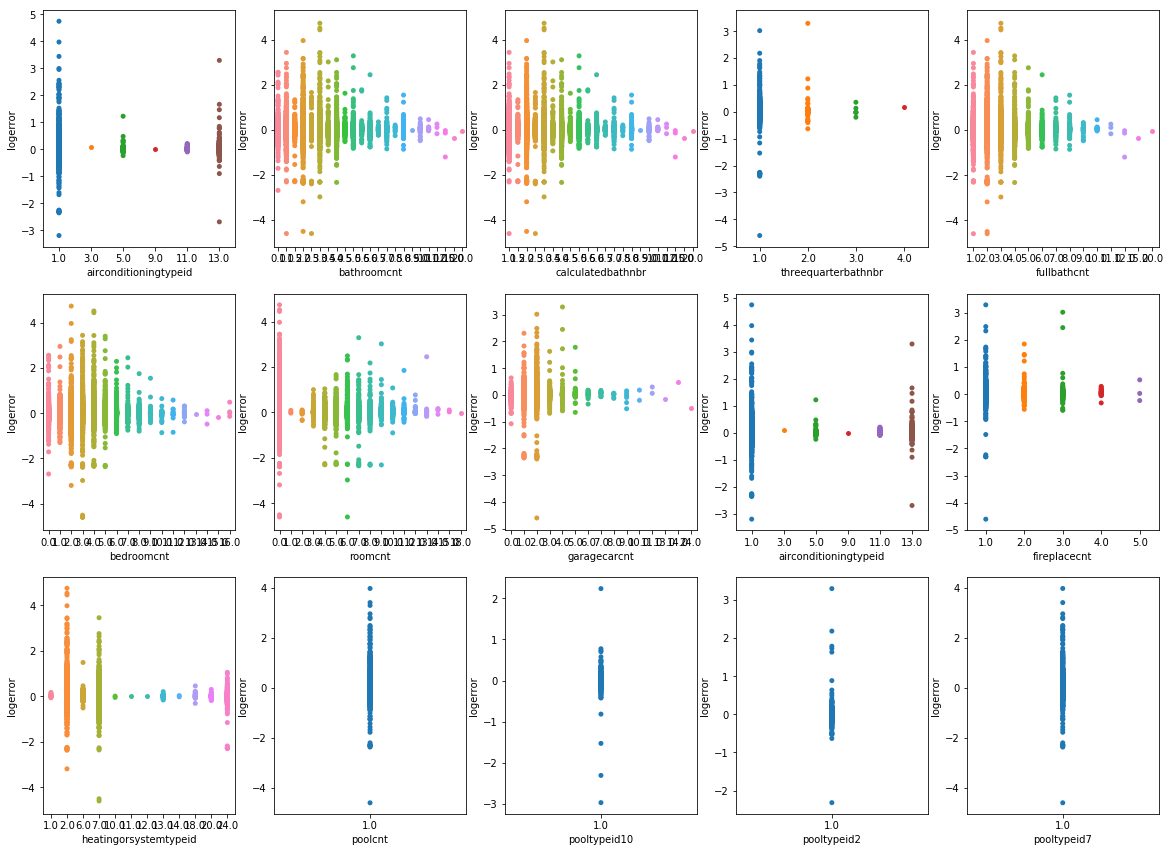

In [15]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_inner_col):
    plt.subplot(4,5,idx+1)
    sns.stripplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

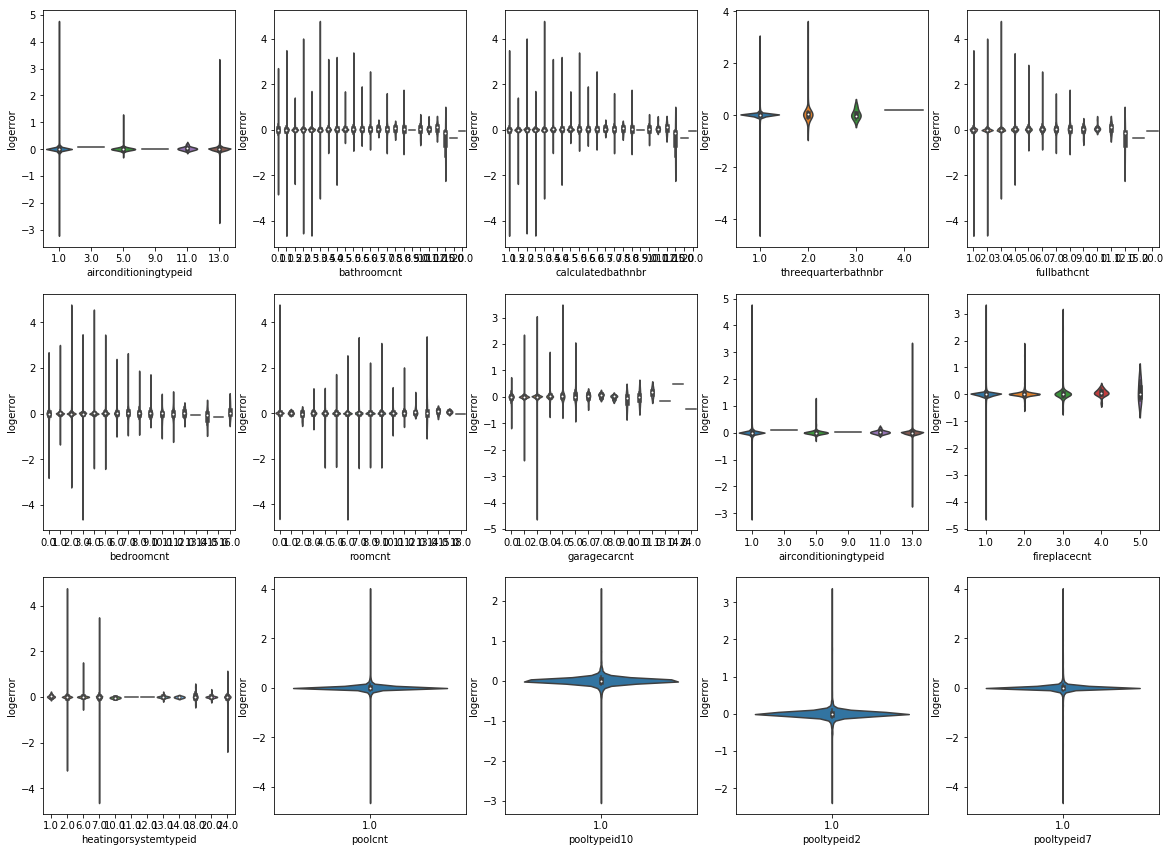

In [16]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_inner_col):
    plt.subplot(4,5,idx+1)
    sns.violinplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- 카테고리가 하나인 컬럼들이 존재한다.
- 카테고리와 분포도를 감안하고 곧 실시할 missing_value가 얼마나 차지할지를 고려하여서 Data cleaning을 실시

마지막으로, object datatype을 가지는 컬럼 2개에 대해서도 countplot으로 시각화를 한다.

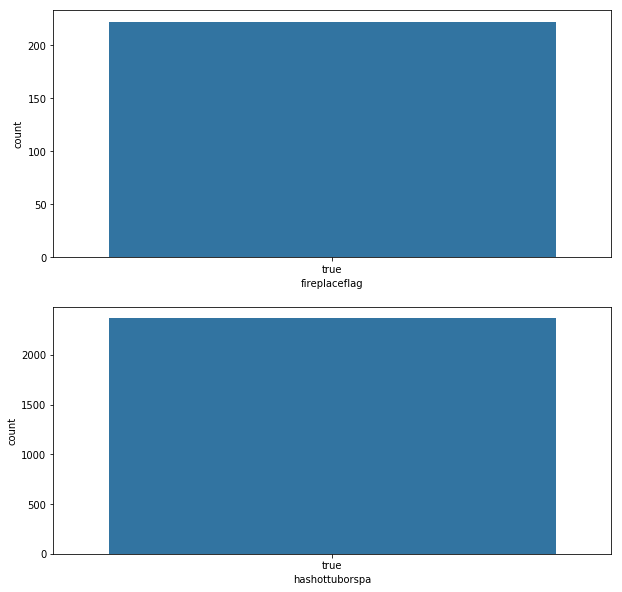

In [17]:
plt.figure(figsize=(10,10))
for idx,col in enumerate(inner_object):
    plt.subplot(2,1,idx+1)
    sns.countplot(train_df[col],data=train_df)
    plt.xlabel(col)
    plt.ylabel('count')
plt.show()

- object datatype에 대한 column 의 countplot을 보면, 카테고리가 하나다. 
- 곧 실시할 data cleaning에서의 imputation strategy에 참고해야 할 사항이다.

# 2) Analysis Missing value 

우선 inner-feature 내의 컬럼들로 구성된 데이터 프레임 'inner_df'를 생성해보겠습니다.

In [18]:
inner_df = train_df[inner_feature_col]
inner_df.tail()

,airconditioningtypeid,bathroomcnt,calculatedbathnbr,threequarterbathnbr,fullbathcnt,bedroomcnt,roomcnt,garagecarcnt,garagetotalsqft,airconditioningtypeid,fireplacecnt,fireplaceflag,hashottuborspa,heatingorsystemtypeid,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7
90270,1.0,1.0,1.0,NaN,1.0,1.0,0.0,NaN,NaN,1.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,1.0
90271,NaN,3.0,3.0,NaN,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
90272,NaN,2.0,2.0,NaN,2.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90273,NaN,2.0,2.0,NaN,2.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
90274,NaN,1.0,1.0,NaN,1.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN


In [19]:
missing_inner_df = inner_df.isnull().sum().reset_index()
missing_inner_df.columns = ['col','missing_cnt']
missing_inner_df['missing_ratio'] = missing_inner_df.missing_cnt / len(inner_df)
missing_inner_df.sort_values(by='missing_ratio',inplace=True)
missing_inner_df.reset_index(inplace=True)
missing_inner_df

,index,col,missing_cnt,missing_ratio
0,1,bathroomcnt,0,0.000000
1,5,bedroomcnt,0,0.000000
2,6,roomcnt,0,0.000000
3,2,calculatedbathnbr,1182,0.013093
4,4,fullbathcnt,1182,0.013093
5,13,heatingorsystemtypeid,34195,0.378787
6,7,garagecarcnt,60338,0.668380
7,8,garagetotalsqft,60338,0.668380
8,0,airconditioningtypeid,61494,0.681185
9,9,airconditioningtypeid,61494,0.681185


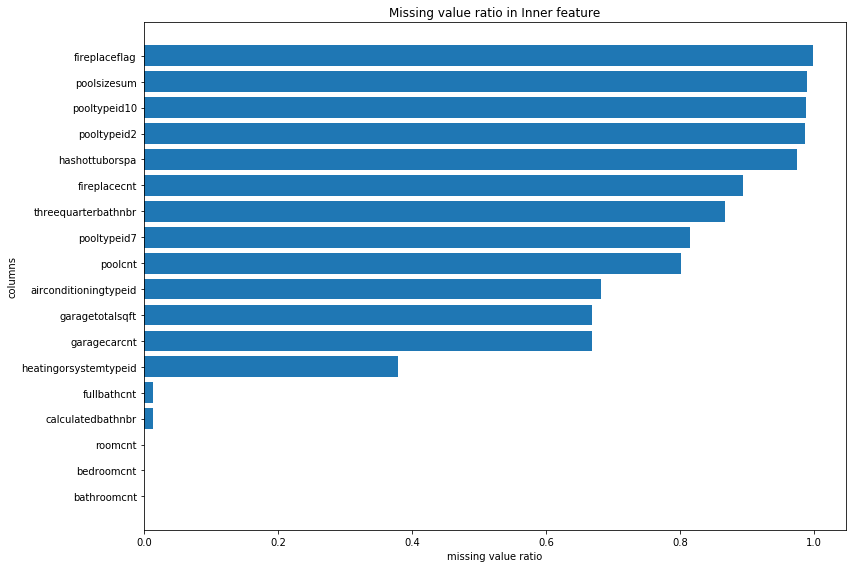

In [20]:
plt.figure(figsize=(12,8))
plt.barh(missing_inner_df.col,missing_inner_df.missing_ratio)
plt.title('Missing value ratio in Inner feature')
plt.xlabel('missing value ratio')
plt.ylabel('columns')
plt.tight_layout()
plt.show()

## 2.1) Fill the Missing data

In [21]:
missing_inner_df

,index,col,missing_cnt,missing_ratio
0,1,bathroomcnt,0,0.000000
1,5,bedroomcnt,0,0.000000
2,6,roomcnt,0,0.000000
3,2,calculatedbathnbr,1182,0.013093
4,4,fullbathcnt,1182,0.013093
5,13,heatingorsystemtypeid,34195,0.378787
6,7,garagecarcnt,60338,0.668380
7,8,garagetotalsqft,60338,0.668380
8,0,airconditioningtypeid,61494,0.681185
9,9,airconditioningtypeid,61494,0.681185


- 위의 missing_ratio를 보면 5개의 컬럼이 NaN값의 비율이 99%가 넘는다. 이는 두 가지 이유로 나눠질 수 있다.
    - 0을 의미 -> 0으로 filling
    - 기록이 누락되었음, 그냥 없는 데이터를 의미 -> deleting columns
- missing_data에 대해서 delete가 아닌 filling을 선택할 때의 경우의 수
    - mean imputation : continous data
    - mode imputation : discrete data , categorical data
    - 'None' or '0' imputation : missing_data means zero in quantitative or qualitative prospect. 

#### bathroomcnt : 0.0%
- Description: 화장실 갯수
- Process: 해당 데이터는 missing_value가 없다. 별 다른 process없이 진행한다. 분포를 좀 더 살펴보면 집별로 화장실 갯수는 2개가 일반적(most common)임을 알 수 있다.

In [22]:
train_df.bathroomcnt.isnull().sum()

0

In [23]:
train_df.bathroomcnt.describe()

count    90275.000000
mean         2.279474
std          1.004271
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: bathroomcnt, dtype: float64

In [24]:
train_df.bathroomcnt.value_counts().sort_values().tail()

4.0     3743
2.5     8091
1.0    15035
3.0    19946
2.0    36534
Name: bathroomcnt, dtype: int64

In [25]:
len(train_df.bathroomcnt.value_counts())

23

#### bedroomcnt	 : 0.0%
- Description: 침실 갯수
- Process: 해당 데이터는 missing_value가 없다. 별 다른 process없이 진행한다. 분포를 좀 더 살펴보면 집별로 침실 갯수는 3개가 일반적(most common)임을 알 수 있다.

In [26]:
train_df.bedroomcnt.isnull().sum()

0

In [27]:
train_df.bedroomcnt.describe()

count    90275.000000
mean         3.031869
std          1.156436
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: bedroomcnt, dtype: float64

In [28]:
train_df.bedroomcnt.value_counts().sort_values().tail()

1.0     3897
5.0     5077
4.0    20279
2.0    22357
3.0    35447
Name: bedroomcnt, dtype: int64

In [29]:
len(train_df.bedroomcnt.value_counts())

17

#### roomcnt	 : 0.0%
- Description: 주거지에있는 총 객실 수
- Process: 해당 데이터는 missing_value가 없다. 별 다른 process없이 진행한다. 분포를 좀 더 살펴보면 위의 다른 컬럼들과는 달리 0값이 많이 나오고 그 다음이 6개의 객실이 많이 나온다. 즉슨, 객실을 가지고 있지 않은 집이 일반적이며 객실이 있는 집들은 그 갯수가 많은 경향성을 띄고 있다고 해석할 수 있다. 집 값에 영향을 미칠 수 있다고 생각한다.

In [30]:
train_df.roomcnt.isnull().sum()

0

In [31]:
train_df.roomcnt.describe()

count    90275.000000
mean         1.478516
std          2.819627
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         18.000000
Name: roomcnt, dtype: float64

In [32]:
train_df.roomcnt.value_counts().sort_values().tail()

8.0     3410
5.0     3486
7.0     4487
6.0     5353
0.0    69700
Name: roomcnt, dtype: int64

In [33]:
len(train_df.roomcnt.value_counts())

17

#### calculatedbathnbr	 : 1.3%
- Description: 화장실 갯수
- Process: 해당 데이터는 위의 bathroomcnt와 같은 것을 의미하는 컬럼이다. 이 컬럼에 대해서 mode로 missing_value을 채워준다.

In [34]:
train_df.calculatedbathnbr = train_df.calculatedbathnbr.fillna(train_df.calculatedbathnbr.mode()[0])

In [35]:
train_df.calculatedbathnbr.describe()

count    90275.000000
mean         2.305168
std          0.970398
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: calculatedbathnbr, dtype: float64

In [36]:
train_df.calculatedbathnbr.value_counts().sort_values().tail()

4.0     3743
2.5     8084
1.0    15035
3.0    19946
2.0    37716
Name: calculatedbathnbr, dtype: int64

In [37]:
len(train_df.calculatedbathnbr.value_counts())

22

#### fullbathcnt	 : 1.3%
- Description: 풀옵션 화장실의 갯수
- Process: 위의 bathroomcnt column과 샘플 측면에서 어떤 것들이 다르게 드러나는지 비교해서 확인해보겠다.

In [38]:
train_df.fullbathcnt = train_df.fullbathcnt.fillna(train_df.fullbathcnt.mode()[0])

In [39]:
train_df.fullbathcnt.describe()

count    90275.000000
mean         2.238073
std          0.957208
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: fullbathcnt, dtype: float64

In [40]:
train_df.fullbathcnt.value_counts().sort_values().tail()

5.0     1392
4.0     4541
1.0    16671
3.0    21035
2.0    45817
Name: fullbathcnt, dtype: int64

In [41]:
len(train_df.fullbathcnt.value_counts())

14

#### heatingorsystemtypeid	 : 37.8%
- Description: 난방 시스템의 타입
- Process: describe method, count_value method를 통해 본결과 난방 시스템은 'Central'이라는 시스템이 가장 일반적으로(most common) 많이 사용되기 때문에, missing_value에 mode값을 넣어준다.

In [42]:
train_df.heatingorsystemtypeid = train_df.heatingorsystemtypeid.fillna(train_df.heatingorsystemtypeid.mode()[0])

In [43]:
train_df.heatingorsystemtypeid.describe()

count    90275.000000
mean         3.197065
std          3.050651
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         24.000000
Name: heatingorsystemtypeid, dtype: float64

In [44]:
train_df.heatingorsystemtypeid.value_counts().sort_values().tail()

20.0       97
6.0       970
24.0     1071
7.0     15519
2.0     72498
Name: heatingorsystemtypeid, dtype: int64

In [45]:
len(train_df.heatingorsystemtypeid.value_counts())

12

In [46]:
train_df.heatingorsystemtypeid = train_df.heatingorsystemtypeid.astype('object')

#### garagecarcnt : 66.83%
- Description: 차고 갯수
- Process: discrete data로써 2개의 차고를 가지고 있는 집들이 가장 많기 때문에 (usual) mode값으로 filling_NaN 을 해준다.

In [47]:
train_df.garagecarcnt = train_df.garagecarcnt.fillna(train_df.garagecarcnt.mode()[0])

In [48]:
train_df.garagecarcnt.describe()

count    90275.000000
mean         1.937657
std          0.361560
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         24.000000
Name: garagecarcnt, dtype: float64

In [49]:
train_df.garagecarcnt.value_counts().sort_values().tail()

4.0      262
0.0      290
3.0      663
1.0     6679
2.0    82280
Name: garagecarcnt, dtype: int64

In [50]:
len(train_df.garagecarcnt.value_counts())

15

#### garagetotalsqft : 66.83%
- Description: 차고 평방(크기)
- Process: 차고 갯수를 나타내는 컬럼과 크기를 나타내는 컬럼의 missing_value 크기가 같다. zillow측에서 조사할 때 쌍으로 같이 조사한 것으로 보인다. 또한, values의 수가 70이며 sqft(volume)을 측정한 것으로 continuous data이다. 또한, min 값이 0이며 하위 25%까지 0값이 있는 것으로 보아 차고가 없으면 0이라고 따로 기제를 한 것이다. 이에 따라 missing_value에는 mean값으로 채워준다.

In [51]:
train_df.garagetotalsqft = train_df.garagetotalsqft.fillna(np.mean(train_df.garagetotalsqft))

In [52]:
train_df.garagetotalsqft.describe()

count    90275.000000
mean       345.521228
std        153.763301
min          0.000000
25%        345.521228
50%        345.521228
75%        345.521228
max       7339.000000
Name: garagetotalsqft, dtype: float64

In [53]:
train_df.garagetotalsqft.value_counts().sort_values().tail()

360.000000      735
441.000000      796
400.000000      970
0.000000       9209
345.521228    60338
Name: garagetotalsqft, dtype: int64

In [54]:
len(train_df.garagetotalsqft.value_counts())

871

#### airconditioningtypeid : 68.16%
- Description: 에이컨 아이디
- Process: 통계치를 보게 되면, 압도적으로 1번 항목인, 'Central'이 많다. 이에 따라 missing_value에 mode값인 1을 취해준다.

In [55]:
train_df.airconditioningtypeid = train_df.airconditioningtypeid.fillna(train_df.airconditioningtypeid.mode()[0])

In [56]:
train_df.airconditioningtypeid.describe()

count    90275.000000
mean         1.260271
std          1.721860
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         13.000000
Name: airconditioningtypeid, dtype: float64

In [57]:
train_df.airconditioningtypeid.value_counts().sort_values().tail()

3.0         1
11.0       63
5.0       215
13.0     1833
1.0     88162
Name: airconditioningtypeid, dtype: int64

In [58]:
len(train_df.airconditioningtypeid.value_counts())

6

In [59]:
train_df.airconditioningtypeid = train_df.airconditioningtypeid.astype('object')

#### poolcnt : 80.17%
- Description: 수영장 갯수
- Process: 통계치에서 1만 있는 데이터가 나온다. 여기서 없는 데이터는 수영장이 없는 집이라고 생각할 수 있다. 따라서 missing_value에는 0을 넣는다.

In [60]:
train_df.poolcnt = train_df.poolcnt.fillna(0)

In [61]:
train_df.poolcnt.describe()

count    90275.000000
mean         0.198294
std          0.398717
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: poolcnt, dtype: float64

In [62]:
train_df.poolcnt.value_counts().sort_values().tail()

1.0    17901
0.0    72374
Name: poolcnt, dtype: int64

In [63]:
len(train_df.poolcnt.value_counts())

2

In [64]:
train_df.poolcnt = train_df.poolcnt.astype('object')

#### pooltypeid7 : 81.50%
- Description: 온수 욕조가없는 수영장
- Process: 통계치에서 1만 있는 데이터가 나온다. 여기서 없는 데이터는 온수욕조가 없는 집이라고 생각할 수 있다. 따라서 missing_value에는 0을 넣는다.

In [65]:
train_df.pooltypeid7 = train_df.pooltypeid7.fillna(0)

In [66]:
train_df.pooltypeid7.describe()

count    90275.000000
mean         0.184957
std          0.388265
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pooltypeid7, dtype: float64

In [67]:
train_df.pooltypeid7.value_counts().sort_values().tail()

1.0    16697
0.0    73578
Name: pooltypeid7, dtype: int64

In [68]:
len(train_df.pooltypeid7.value_counts())

2

In [69]:
train_df.pooltypeid7 = train_df.pooltypeid7.astype('object')

#### threequarterbathnbr : 86.69%
- Description:집 내 3/4 욕실 수 (샤워 + 세면대 + 화장실)
- Process: 샤워,세면대,화장실을 모두 가지고 있는 욕실을 의미하는 것으로 없는 값은 이를 충족하지 못하는 집이라고 간주, 0을 채워준다.

In [70]:
train_df.threequarterbathnbr = train_df.threequarterbathnbr.fillna(0)

In [71]:
train_df.threequarterbathnbr.describe()

count    90275.000000
mean         0.134190
std          0.344543
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: threequarterbathnbr, dtype: float64

In [72]:
train_df.threequarterbathnbr.value_counts().sort_values().tail()

4.0        1
3.0        6
2.0       90
1.0    11912
0.0    78266
Name: threequarterbathnbr, dtype: int64

In [73]:
len(train_df.threequarterbathnbr.value_counts())

5

#### hashottuborspa :97.38%
- Description:난방 시스템의 유무
- Process: 해당 컬럼은 True or False 형태의 dtype:Object 인 컬럼이다. NaN 값에 False를 넣어준다.

In [74]:
train_df.hashottuborspa  = train_df.hashottuborspa .fillna('False')

In [75]:
train_df.hashottuborspa.describe()

count     90275
unique        2
top       False
freq      87910
Name: hashottuborspa, dtype: object

In [76]:
train_df.hashottuborspa.value_counts().sort_values().tail()

true      2365
False    87910
Name: hashottuborspa, dtype: int64

In [77]:
len(train_df.hashottuborspa.value_counts())

2

#### fireplacecnt :89.35%
- Description:벽난로 수
- Process: 해당 컬럼의 value을 살펴보면 1-5까지가 있다. 즉 missing_value의 의미는 벽난로가 없는 집을 의미한다. NaN -> 0

In [78]:
train_df.fireplacecnt  = train_df.fireplacecnt .fillna(0)

In [79]:
train_df.fireplacecnt.describe()

count    90275.000000
mean         0.126414
std          0.398912
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.000000
Name: fireplacecnt, dtype: float64

In [80]:
train_df.fireplacecnt.value_counts().sort_values().tail()

4.0       21
3.0      312
2.0     1106
1.0     8165
0.0    80668
Name: fireplacecnt, dtype: int64

In [81]:
len(train_df.fireplacecnt.value_counts())

6

####  pooltypeid2 :  98.66%
- Description: 스파 / 온수 욕조가있는 수영장
- Process: 있다 없다로 나타내기 위해서 1이라는 데이터만 있는 상태이다. 없는 NaN값에 0을 넣어준다.

In [82]:
train_df.pooltypeid2  = train_df.pooltypeid2 .fillna(0)

In [83]:
train_df.pooltypeid2.describe()

count    90275.000000
mean         0.013337
std          0.114714
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pooltypeid2, dtype: float64

In [84]:
train_df.pooltypeid2.value_counts().sort_values().tail()

1.0     1204
0.0    89071
Name: pooltypeid2, dtype: int64

In [85]:
len(train_df.pooltypeid2.value_counts())

2

In [86]:
train_df.pooltypeid2 = train_df.pooltypeid2.astype('object')

#### pooltypeid10 : 98.71%
- Description:   온수 욕조가없는 수영장
- Process: 있다 없다로 나타내기 위해서 1이라는 데이터만 있는 상태이다. 없는 NaN값에 0을 넣어준다.

In [87]:
train_df.pooltypeid10  = train_df.pooltypeid10 .fillna(0)

In [88]:
train_df.pooltypeid10.describe()

count    90275.000000
mean         0.012861
std          0.112674
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pooltypeid10, dtype: float64

In [89]:
train_df.pooltypeid10.value_counts().sort_values().tail()

1.0     1161
0.0    89114
Name: pooltypeid10, dtype: int64

In [90]:
len(train_df.pooltypeid10.value_counts())

2

In [91]:
train_df.pooltypeid10 = train_df.pooltypeid10.astype('object')

#### poolsizesum : 98.92%
- Description:  수영장 크기
- Process: value_counts결과값이 매우 다양하다. 없는 데이터는 NaN 에 0을 넣으므로써 수영장이 없는 집임을 나타낼 수 있다. missing_value에 0으로 채운다.

In [92]:
train_df.poolsizesum  = train_df.poolsizesum .fillna(0)

In [93]:
train_df.poolsizesum.describe()

count    90275.000000
mean         5.579762
std         55.921469
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1750.000000
Name: poolsizesum, dtype: float64

In [94]:
train_df.poolsizesum.value_counts().sort_values().tail()

500.0       36
800.0       39
400.0       41
450.0      105
0.0      89306
Name: poolsizesum, dtype: int64

In [95]:
len(train_df.poolsizesum.value_counts())

274

#### fireplaceflag : 99.75%
- Description:  벽난로가 있는지 없는지
- Process: True or False 로 나뉘어져 있는 데이터이며, False를 나타내는 데이터가 누락된 것으로 보인다. missing_value를 'False'로 채워준다.

In [96]:
train_df.fireplaceflag  = train_df.fireplaceflag .fillna('False')

In [97]:
train_df.fireplaceflag.describe()

count     90275
unique        2
top       False
freq      90053
Name: fireplaceflag, dtype: object

In [98]:
train_df.fireplaceflag.value_counts().sort_values().tail()

true       222
False    90053
Name: fireplaceflag, dtype: int64

In [99]:
len(train_df.fireplaceflag.value_counts())

2

## Feature Correlation
- 종속 변수 y vs 독립 변수 x
    - correlation barh plot
- 독립 변수 x vs 독립 변수 x
    - heatmap

In [100]:
numerical_features = [col for col in inner_feature_col if train_df[col].dtypes != 'object']
categorical_features = [col for col in inner_feature_col if train_df[col].dtypes == 'object']
len(numerical_features),len(categorical_features)

(10, 9)

### Numerical columns VS Logerror  Correlation plot

In [101]:
correl_val = []
for col in numerical_features:
    correl_val.append(np.corrcoef(train_df['logerror'],train_df[col])[0][1])
len(correl_val)

10

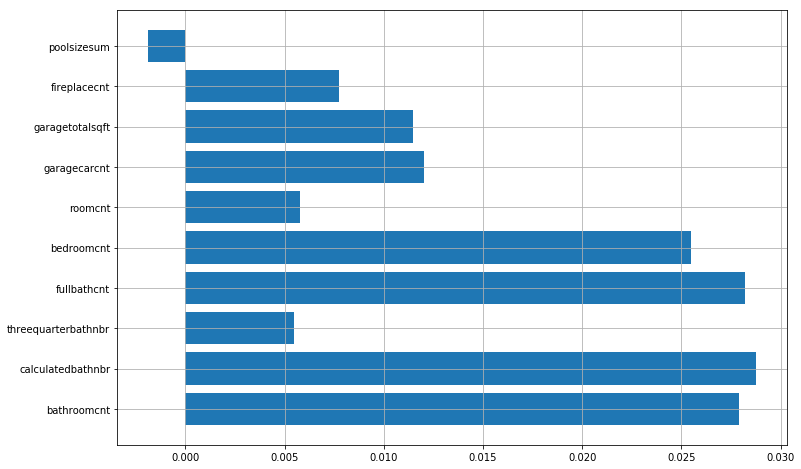

In [102]:
plt.figure(figsize=(12,8))
plt.grid(True)
plt.barh(numerical_features,correl_val)
plt.show()

### Comment:
- 전체적으로 높은 상관관계가 보여지지는 않는다.
- 상대적으로 높은 컬럼으로는 bathroomcnt, calculatebathnbr, bedroomcnt, fullbathcnt가 있다.

## Columns vs Columns heatmap

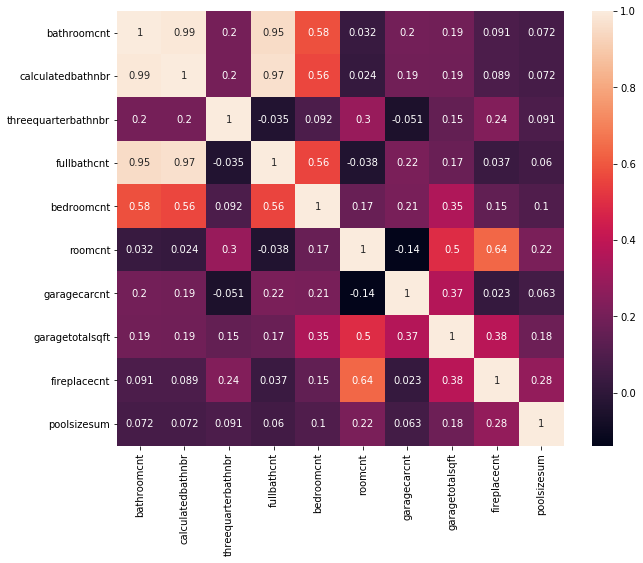

In [103]:
corrmat = train_df[numerical_features].corr(method = 'spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corrmat,annot=True)
plt.show()

### Comment:
- 이는 독립변수 간의 상관관계를 나타내는 heatmap을 그려본 것이다.
- 상관관계가 높은 columns들이 있음을 알 수 있다.
- 눈에 띄는 컬럼들로는 
    - calculatedbathnbr vs bathroomcnt
    - fullbathcnt vs bathroomcnt
    - fullbathcnt vs calculatebathnbr
    - fireplacecnt vs roomcnt
    - bedroomcnt vs bathroomcnt, calculatedbathnbr, fullbathcnt
- 상관관계가 매우 높은 컬럼으로 calculatedbathnbr vs bathroomcnt, fullbathcnt vs bathroomcnt, fullbathcnt vs calculatebathnbr 가 있는데, description을 보게 되면 이 컬럼들 모두 bathroom과 관련되어 있는 것임을 알 수 있다. 높은 상관관계를 띄고 있기 때문에 선형회귀모형 가정을 충족시키기 위해서 일부 컬럼의 삭제가 진행되어야 한다.
- 나머지 컬럼들에 대한 처리는 후에 진행될 VIF 와 함께 추가적으로 실시한다.

# Feature Engineering
- Categorical Feature engineering
- Numerical Feature engineering

## Categorical Feature engineering

In [ ]:
numeric_dfX = train_df[numerical_features]
cat_dfX = train_df[categorical_features]
dfy = train_df['logerror']

In [183]:
train_df.fireplaceflag = dmatrix('C(fireplaceflag)',train_df)
train_df.hashottuborspa = dmatrix('C(hashottuborspa)',train_df)
train_df.heatingorsystemtypeid = dmatrix('C(heatingorsystemtypeid)',train_df)

In [212]:
orgin_cat_model = sm.OLS.from_formula('logerror ~ C(airconditioningtypeid) + C(fireplaceflag) + C(hashottuborspa) + C(heatingorsystemtypeid) + C(poolcnt) + C(pooltypeid10) + C(pooltypeid2) + C(pooltypeid7) + 0',data=train_df)
orgin_cat_result = orgin_cat_model.fit()

In [213]:
print(orgin_cat_result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.282
Date:                Wed, 04 Jul 2018   Prob (F-statistic):              0.241
Time:                        19:22:27   Log-Likelihood:                 36741.
No. Observations:               90275   AIC:                        -7.346e+04
Df Residuals:                   90265   BIC:                        -7.337e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
C(airconditi

Multicollinearity problem 발생

## F-test

In [197]:
sm.stats.anova_lm(cat_result).sort_values(by='PR(>F)')

/home/hskimim/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/hskimim/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/hskimim/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
C(airconditioningtypeid),6.0,11.904779,1.984130,76.498598,1.008665e-95
C(heatingorsystemtypeid),11.0,0.926262,0.084206,3.246568,1.893045e-04
C(poolcnt),1.0,0.314823,0.314823,12.138060,4.942655e-04
C(pooltypeid10),1.0,0.055052,0.055052,2.122541,1.451490e-01
C(pooltypeid2),1.0,0.011633,0.011633,0.448506,5.030468e-01
C(pooltypeid7),1.0,0.002461,0.002461,0.094900,7.580386e-01
C(fireplaceflag),0.0,0.000000,NaN,NaN,NaN
C(hashottuborspa),0.0,0.000000,NaN,NaN,NaN
Residual,90255.0,2340.927063,0.025937,NaN,NaN


- 해당 컬럼의 중요도가 0이다 라는 귀무가설에 대한 신뢰수준을 나타내는 PR(>F) 부분에 대해서 점검을 한다.
- 우선 중요도값이 NaN이 나온 컬럼들을 제거해준다.
- 또한 자릿수가 e-01인 컬럼들도 제거해준다.

In [214]:
revised_cat_result = sm.OLS.from_formula('logerror ~ C(airconditioningtypeid) + C(heatingorsystemtypeid) + C(poolcnt)+ 0',data=train_df)
revised_cat_result  = cat_model.fit()

In [215]:
print(revised_cat_result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.755
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           5.91e-05
Time:                        19:23:52   Log-Likelihood:                 36762.
No. Observations:               90275   AIC:                        -7.348e+04
Df Residuals:                   90255   BIC:                        -7.330e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
C(aircon

조건수가 매우 크다

## Numerical Data Feature Engineering

In [198]:
numeric_model = sm.OLS.from_formula('logerror~ scale(bathroomcnt) + scale(calculatedbathnbr) + scale(threequarterbathnbr) + scale(fullbathcnt) + scale(bedroomcnt) + scale(roomcnt) + scale(garagecarcnt) + scale(garagetotalsqft) + scale(fireplacecnt) + scale(poolsizesum)',data=train_df)
result = numeric_model.fit()

In [116]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     9.333
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           1.19e-15
Time:                        08:22:28   Log-Likelihood:                 36782.
No. Observations:               90275   AIC:                        -7.354e+04
Df Residuals:                   90264   BIC:                        -7.344e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

조건수가 매우 크다.

In [199]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

## VIF

In [200]:
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(numeric_dfX.values, i) for i in range(numeric_dfX.shape[1])]
vif["features"] = numeric_dfX.columns
vif

/home/hskimim/anaconda3/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,134.036496,bathroomcnt
1,inf,calculatedbathnbr
2,inf,threequarterbathnbr
3,inf,fullbathcnt
4,14.048889,bedroomcnt
5,2.353895,roomcnt
6,16.449328,garagecarcnt
7,10.889146,garagetotalsqft
8,1.933970,fireplacecnt
9,1.147959,poolsizesum


calculatedbathnbr , threequarterbathnbr , fullbathcnt 의 VIF가 inifinite로 나왔다. 이 컬럼들을 빼고 다시 OLS

## F 검정을 사용한 변수 중요도 비교

In [202]:
sm.stats.anova_lm(result,typ=2).sort_values(by='PR(>F)')

,sum_sq,df,F,PR(>F)
scale(bedroomcnt),0.245190,1.0,9.458579,0.002102
scale(poolsizesum),0.104638,1.0,4.036582,0.044527
scale(bathroomcnt),0.071385,1.0,2.753773,0.097029
scale(garagecarcnt),0.069429,1.0,2.678347,0.101725
scale(fireplacecnt),0.028568,1.0,1.102038,0.293822
scale(calculatedbathnbr),0.028324,1.0,1.092643,0.295889
scale(threequarterbathnbr),0.028324,1.0,1.092643,0.295889
scale(fullbathcnt),0.028324,1.0,1.092643,0.295889
scale(roomcnt),0.010231,1.0,0.394677,0.529853
scale(garagetotalsqft),0.005501,1.0,0.212194,0.645054


In [204]:
orgin_numeric_model = sm.OLS.from_formula('logerror~ scale(bathroomcnt) + scale(calculatedbathnbr) + scale(threequarterbathnbr) + scale(fullbathcnt) + scale(bedroomcnt) + scale(roomcnt) + scale(garagecarcnt) + scale(garagetotalsqft) + scale(fireplacecnt) + scale(poolsizesum)',data=train_df)
revised_numeric_model = sm.OLS.from_formula('logerror~ scale(bathroomcnt)+ scale(bedroomcnt) + scale(garagecarcnt)+ scale(poolsizesum)',data=train_df)

In [209]:
revised_numeric_result = revised_numeric_model.fit()
print(revised_numeric_result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     20.90
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           3.05e-17
Time:                        19:16:19   Log-Likelihood:                 36777.
No. Observations:               90275   AIC:                        -7.354e+04
Df Residuals:                   90270   BIC:                        -7.350e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0115    

- 전체적으로 F test statistics 가 너무 높다.
- F-test statistics 에 따르면 fireplacecnt, calculatedvathnbr, threequarterbathnbr, fullbathcnt, roomcnt, garagetotalsqft 이렇게 높다.

# Overall Test

In [217]:
inner_feature_model = sm.OLS.from_formula('logerror~ scale(bathroomcnt)+ scale(bedroomcnt) + scale(garagecarcnt)+ scale(poolsizesum) + C(airconditioningtypeid) + C(heatingorsystemtypeid) + C(poolcnt)',data=train_df)
inner_feature_result = inner_feature_model.fit()
print(inner_feature_result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     10.45
Date:                Wed, 04 Jul 2018   Prob (F-statistic):           7.06e-18
Time:                        19:25:16   Log-Likelihood:                 36788.
No. Observations:               90275   AIC:                        -7.355e+04
Df Residuals:                   90264   BIC:                        -7.345e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

- 조건수는 줄였는데, 결정계수가 많이 낮다.
- Ominbus test , Jarque-Bera 결과가 많이 높다.
- F-statistic 이 많이 높다. 